### Other encoded assets

In [2]:
# Input
date = '2018_09_21'
homePath = 'C:/Users/Mamed/Python4DS/'
projPath = homePath + 'FundsBR/'
strucPath = projPath + 'Structures_' + date + '/'
libsPath = projPath + 'Libs/'

In [3]:
import pandas as pd
import numpy as np
from collections import Counter
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
from IPython.display import clear_output
import copy

# Load my libraries
exec(open(libsPath + 'fundsLib.py').read())

#### Other encoded assets (blk 4)

In [4]:
# Read BLC
dfBLC = pd.read_pickle(strucPath + 'BLC_blk_4_.pkl')
l0 = dfBLC.shape[0]
print('{:>12,.0f} rows {:>6,.0f} columns'.format(dfBLC.shape[0], dfBLC.shape[1]))

   7,723,080 rows     21 columns


In [ ]:
# Summary
dfSummary(dfBLC)

In [5]:
# The confidentiality period (last 3 months) will have null 'CD_ATIVO',
# i.e., for that dates, we will not be able to see the assets.
# Therefore, we delete those rows.
dfBLC = dfBLC[~dfBLC['CD_ATIVO'].apply(pd.isnull)].reset_index(drop = True)
l1 = dfBLC.shape[0]
print('Deleted rows: {:<20,.0f}'.format(l0 - l1))

Deleted rows: 86,236              


In [9]:
# Four date columns have to be convervet from string to datestamp
dfBLC['DT_COMPTC'] = pd.to_datetime(dfBLC['DT_COMPTC'])
dfBLC['DT_CONFID_APLIC'] = pd.to_datetime(dfBLC['DT_CONFID_APLIC'])
dfBLC['DT_INI_VIGENCIA'] = pd.to_datetime(dfBLC['DT_INI_VIGENCIA'])

# No that differently of other assets blocks, in this case we have stocks.
# For them, the fild 'DT_FIM_VIGENCIA' sometimes is filled with the value
# '9999-12-31'. For that reason, we need to include the "errors = 'coerce'"
# option in the dates convertion function. In that case, the '9999' dates
# will be converted as 'NaT', otherwise it would raise an error.
dfBLC['DT_FIM_VIGENCIA'] = pd.to_datetime(dfBLC['DT_FIM_VIGENCIA'], 
    errors = 'coerce')

In [ ]:
# Summary
dfSummary(dfBLC)

In [ ]:
seriesSummary(dfBLC, 'TP_APLIC', 0, 50, 'head')

In [ ]:
seriesSummary(dfBLC, 'TP_ATIVO', 0, 0, 'head')

### Stocks

In [140]:
# We will look separately to Stocks
dfStk = dfBLC.copy(deep = True)
dfStk = dfStk[dfStk['TP_APLIC'] == 'Ações'].reset_index(drop = True)
print('{:>12,.0f} rows {:>6,.0f} columns'.format(dfStk.shape[0], dfStk.shape[1]))

   5,185,288 rows     21 columns


In [11]:
dfSummary(dfStk)

RangeIndex: 5185288 entries, 0 to 5185287
Data columns (total 21 columns):

                           colType   Unique      NaN
TP_FUNDO                    object       12        0
CNPJ_FUNDO                  object     6577        0
DENOM_SOCIAL                object     6584        0
DT_COMPTC           datetime64[ns]      164        0
TP_APLIC                    object        1        0
TP_ATIVO                    object        2        0
EMISSOR_LIGADO              object        2   738118
TP_NEGOC                    object        2        0
QT_VENDA_NEGOC             float64   162080   514218
VL_VENDA_NEGOC             float64  1679252   514218
QT_AQUIS_NEGOC             float64   164278   514186
VL_AQUIS_NEGOC             float64  1807293   514186
QT_POS_FINAL               float64   465832        0
VL_MERC_POS_FINAL          float64  2573141        0
VL_CUSTO_POS_FINAL         float64   470148  4447170
DT_CONFID_APLIC     datetime64[ns]      705  2380473
CD_ATIVO               

#### Stocks' lifespan, i.e., time between first and last apperance in the database

In [141]:
# Asset lifeSpan
d = dfStk.groupby(['CD_ATIVO'])['DT_COMPTC']
dfLS = pd.DataFrame(data = [d.min(), d.max()], index = ['dtMin', 'dtMax']).T
dfLS['lifeSpan'] = dfLS['dtMax'] - dfLS['dtMin']
dfLS['lifeSpan'] = dfLS['lifeSpan'].apply(lambda x: x.days + 1)

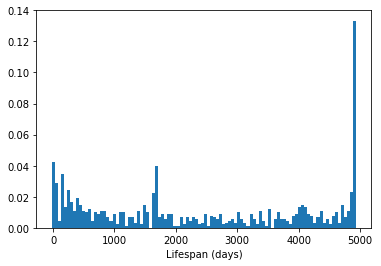

In [142]:
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)
hist, bins = np.histogram(dfLS['lifeSpan'], bins = 100)
plt.bar(bins[:-1], hist.astype(np.float32)/hist.sum(), width = (bins[1]-bins[0]))
plt.xlabel('Lifespan (days)')
plt.show()

In [143]:
# 25% of the stocks (0.25 * 900 = 225) lived untill 730 days
# Note we had t = 1 lifespan! I.e., one day only...
dfLS['lifeSpan'].describe()

count     900.000000
mean     2463.397778
std      1784.136876
min         1.000000
25%       731.000000
50%      2193.000000
75%      4210.000000
max      4961.000000
Name: lifeSpan, dtype: float64

#### A liquidity measure: How many fund had positions in each stock at least for one day?

In [144]:
nFunds = dfStk.groupby(['CD_ATIVO', 'CNPJ_FUNDO'])['CNPJ_FUNDO'].count()
nFunds = nFunds.unstack(level = 1)
nFunds = ~nFunds.applymap(np.isnan)
nFunds = nFunds.sum(axis = 1)
nFunds.name = 'nFunds'

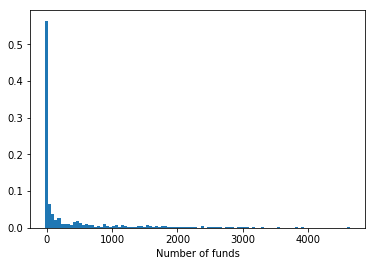

In [145]:
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)
hist, bins = np.histogram(nFunds, bins = 100)
plt.bar(bins[:-1], hist.astype(np.float32)/hist.sum(), width = (bins[1]-bins[0]))
plt.xlabel('Number of funds')
plt.show()

In [146]:
# 25% of the stocks (0.25 * 900 = 225) have been traded in the maximum
# number of 3 funds. Is it the case of adventure capital? We have to 
# investigate.
# Note we had stocks traded only by one fund.
nFunds.describe()

count     900.000000
mean      355.462222
std       677.177940
min         1.000000
25%         3.000000
50%        28.000000
75%       367.500000
max      4659.000000
Name: nFunds, dtype: float64

#### How is the joint distribution of lifespan and liquidity?
Concentration in lifespans < 1500 and > 3500, for tradings number < 400.

In [147]:
dfLiq = pd.concat([dfLS['lifeSpan'], nFunds], axis=1)

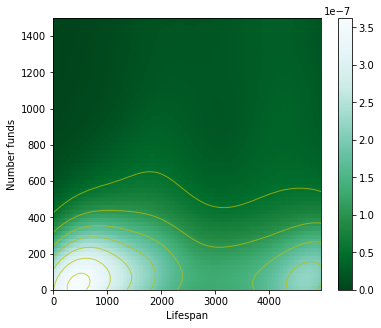

In [148]:
# Atention: the axes units are wrong
from scipy.stats import kde
fig = plt.figure(figsize = (6, 5))
ax = fig.add_subplot(111)

x = dfLiq['lifeSpan']; y = dfLiq['nFunds']

nbins = 200
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
im = plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.BuGn_r)
ax.contour(xi, yi, zi.reshape(xi.shape), colors = 'y', alpha = 0.7, 
    linewidths = 1)
fig.colorbar(im)

ax.set_ylim((0, 1500))
plt.xlabel('Lifespan')
plt.ylabel('Number funds')
plt.show()

#### We will label as 'others' stocks with:
* lifespan smaller than 90 days; or
* less than 25 funds holdings

In [149]:
dfLiq['liq'] = np.where((dfLiq['lifeSpan'] < 90) | (dfLiq['nFunds'] < 25), 
    'illiquid', 'liquid')

In [150]:
dfLiq.sample(5)

,lifeSpan,nFunds,liq
CD_ATIVO,,,
ECOR3,1705,698,liquid
TRPN3,3380,105,liquid
COBE6B,2374,2,illiquid
PALF6,246,1,illiquid
BRKM6,1,1,illiquid


In [151]:
# List of illiquid stocks
nonLiquid = dfLiq['liq'][dfLiq['liq'] == 'illiquid'].index
nonLiquid

Index(['ABCB3', 'ADHM3', 'AEDU4', 'AESL3', 'AETA3', 'AFLT3', 'AFLU3', 'AFLU5',
       'AGLS3', 'AGLS3B',
       ...
       'VPSC3', 'VPSC4', 'VPTA3', 'VVAR3', 'VVAR4', 'WHRL3', 'WISA4', 'WLMM3',
       'WLMM4', 'rbra3'],
      dtype='object', name='CD_ATIVO', length=435)

In [152]:
# Apply "OTHER" to stock data
dfStk['CD_ATIVO'] = dfStk['CD_ATIVO'].apply(lambda x: 'OTHER' if x in nonLiquid else x)

In [153]:
# Number of OTHERs
len(dfStk['CD_ATIVO'][dfStk['CD_ATIVO'] == 'OTHER'])

34684

### Computing stocks unitary prices

In [154]:
# Delete rows where 'QT_POS_FINAL' = 0
dfStk = dfStk[dfStk['QT_POS_FINAL'] != 0].reset_index(drop = True)

In [155]:
# Delete rows where 'VL_MERC_POS_FINAL' = 0
dfStk = dfStk[dfStk['VL_MERC_POS_FINAL'] != 0].reset_index(drop = True)

In [156]:
# Delete rows where 'CD_ATIVO' = 'OTHERS'
dfStk = dfStk[dfStk['CD_ATIVO'] != 'OTHERS'].reset_index(drop = True)

In [157]:
# Compute unitary price column
dfStk['PU'] = dfStk['VL_MERC_POS_FINAL'] / dfStk['QT_POS_FINAL']

In [230]:
# Compute the mode for each stock CD_ATIVO and observation date
# The mode aggregation (most frequent) is usefull to exclude outliers
# The '.mean()' applyed after '.mode()' is necessary once mode output
# may have more than one value. In this case, we the the mean of it
mode = lambda x: x.mode().mean()# if len(x) > 2 else x.mean()
unitPrc = dfStk.groupby(['CD_ATIVO', 'DT_COMPTC'])['PU'].agg(mode)

In [235]:
# Most frequent stocks, used as filter in the plot chunck below
stkCode = dfStk.groupby(['CD_ATIVO'])['TP_FUNDO'].count()\
    .sort_values(ascending = False)

In [237]:
# DF containg prices with dates in rows and stock code in columns
dfPrices = unitPrc.unstack(level = 0)

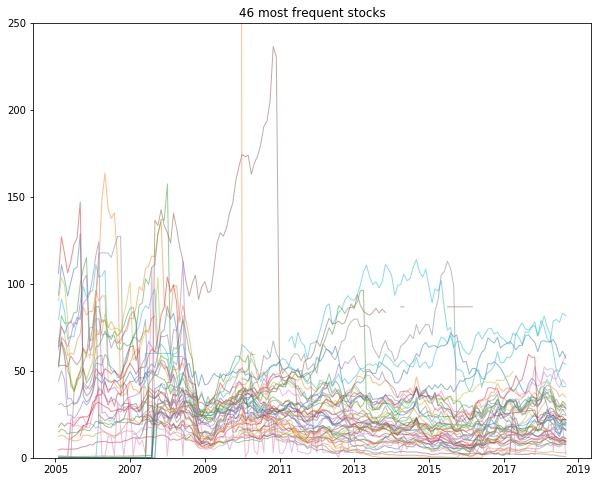

In [267]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111)

# Most frequent stocks filter
perc = 0.1
stkNames = stkCode.head(int(perc * len(stkCode))).index

# Plot price series for each bond 
for stk in dfPrices[stkNames]:
    plt.plot(dfPrices.index, dfPrices[stk], linewidth = 1.0, alpha = 0.5)

ax.set_title(str(int(perc * len(stkCode))) +  ' most frequent stocks')
ax.set_ylim((0, 250))
plt.show()

### Holdings by fund

In [437]:
# Funds stock position by CD_ATIVO and date (multi indices series)
stk_by_fund = dfStk.groupby(['DT_COMPTC', 'CNPJ_FUNDO', 'CD_ATIVO'])\
    ['VL_MERC_POS_FINAL'].sum()
stk_by_fund.name = 'stocks'

In [438]:
# Get dates
dates = sorted(list(set(stk_by_fund.index.get_level_values(0))))

In [491]:
dates

[Timestamp('2005-01-31 00:00:00'),
 Timestamp('2005-02-28 00:00:00'),
 Timestamp('2005-03-31 00:00:00'),
 Timestamp('2005-04-30 00:00:00'),
 Timestamp('2005-05-31 00:00:00'),
 Timestamp('2005-06-30 00:00:00'),
 Timestamp('2005-07-31 00:00:00'),
 Timestamp('2005-08-31 00:00:00'),
 Timestamp('2005-09-30 00:00:00'),
 Timestamp('2005-10-31 00:00:00'),
 Timestamp('2005-11-30 00:00:00'),
 Timestamp('2005-12-31 00:00:00'),
 Timestamp('2006-01-31 00:00:00'),
 Timestamp('2006-02-28 00:00:00'),
 Timestamp('2006-03-31 00:00:00'),
 Timestamp('2006-04-30 00:00:00'),
 Timestamp('2006-05-31 00:00:00'),
 Timestamp('2006-06-30 00:00:00'),
 Timestamp('2006-07-31 00:00:00'),
 Timestamp('2006-08-31 00:00:00'),
 Timestamp('2006-09-30 00:00:00'),
 Timestamp('2006-10-31 00:00:00'),
 Timestamp('2006-11-30 00:00:00'),
 Timestamp('2006-12-31 00:00:00'),
 Timestamp('2007-01-31 00:00:00'),
 Timestamp('2007-02-28 00:00:00'),
 Timestamp('2007-03-31 00:00:00'),
 Timestamp('2007-04-30 00:00:00'),
 Timestamp('2007-05-

In [439]:
# For each date in 'dates', compute mkt total n. of funds, number of holded 
# stocks, total holded value and mean holded value

funds_count = []
stock_count = []
mkt_value_tot = []
mkt_value_mean = []

for dt in dates:
    
    # CNPJ/CD_ATIVO multi index serie for specific date 'dt'
    stk_by_fund_dt = stk_by_fund.xs(dt)

    # Dataframe CNPJ x CD_ATIVO for date 'dt
    stk_by_fund_dt = stk_by_fund_dt.unstack(level = 1).fillna(0)

    # Number of funds
    funds_count += [stk_by_fund_dt.shape[0]]

    # Number of stocks
    stock_count += [stk_by_fund_dt.shape[1]]

    # Total stock holdings value per fund
    mkt_value = stk_by_fund_dt.sum(axis=1)

    # Total stock market value (billions)
    mkt_value_tot += [mkt_value.sum() / 10**9]

    # Mean stock market holdings (millions)
    mkt_value_mean += [mkt_value.mean() / 10**6]

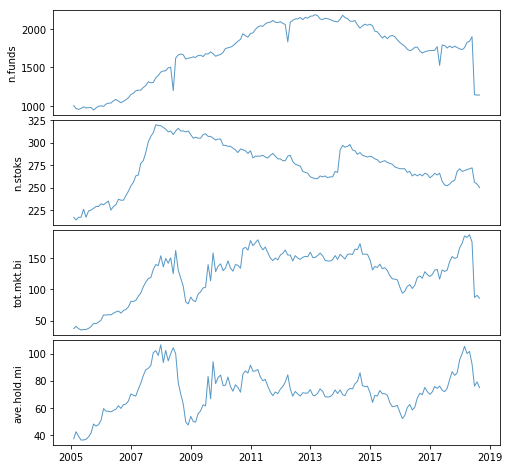

In [440]:
fig = plt.figure(figsize = (8, 8))
gs = gridspec.GridSpec(ncols = 1, nrows = 4, hspace = 0.05)

ax = fig.add_subplot(gs[0, 0])
plt.plot(dates, funds_count, linewidth = 1.0, alpha = 0.75)
ax.get_xaxis().set_ticks([])
plt.ylabel('n.funds')

ax = fig.add_subplot(gs[1, 0])
plt.plot(dates, stock_count, linewidth = 1.0, alpha = 0.75)
ax.get_xaxis().set_ticks([])
plt.ylabel('n.stoks')

ax = fig.add_subplot(gs[2, 0])
plt.plot(dates, mkt_value_tot, linewidth = 1.0, alpha = 0.75)
ax.get_xaxis().set_ticks([])
plt.ylabel('tot.mkt.bi')

ax = fig.add_subplot(gs[3, 0])
plt.plot(dates, mkt_value_mean, linewidth = 1.0, alpha = 0.75)
plt.ylabel('ave.hold.mi')

plt.show()

In [504]:
from sklearn.cluster import KMeans
kmax = 20


distorsions = []
for dt in dates:

    # CNPJ/CD_ATIVO multi index serie for specific date 'dt'
    stk_by_fund_dt = stk_by_fund.xs(dt)

    # Dataframe CNPJ x CD_ATIVO for date 'dt
    stk_by_fund_dt = stk_by_fund_dt.unstack(level = 1).fillna(0)

    # Convert to percentage by row. I.e., rows contain each fund percentual 
    # position by stock.

    # Copy df
    stk_by_fund_dt_perc = stk_by_fund_dt.copy(deep = True)

    # Total by row
    col_list = list(stk_by_fund_dt_perc)
    stk_by_fund_dt_perc['total'] = stk_by_fund_dt_perc[col_list].sum(axis=1)

    # Percentage position
    stk_by_fund_dt_perc = stk_by_fund_dt_perc.div(stk_by_fund_dt_perc['total'], 
        axis = 'index')

    # Drop Total column
    stk_by_fund_dt_perc = stk_by_fund_dt_perc.drop(['total'], axis = 1)

    # Kmeans, elbow method
    X = stk_by_fund_dt_perc

    distorsions_ = []
    for k in range(2, kmax):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        distorsions_.append(kmeans.inertia_)

    distorsions. append(distorsions_)

In [508]:
z = np.array(distorsions)

In [509]:
z.shape

(164, 18)

In [512]:
z[0, :]

array([ 234.99403328,  182.29197619,  150.66099682,  126.8813984 ,
        115.4628864 ,  108.47365696,  102.7302626 ,   98.66027899,
         95.62536152,   91.89850674,   89.89104279,   87.18070102,
         84.98834902,   81.54464949,   78.6966348 ,   77.70629494,
         76.31546116,   74.20369919])

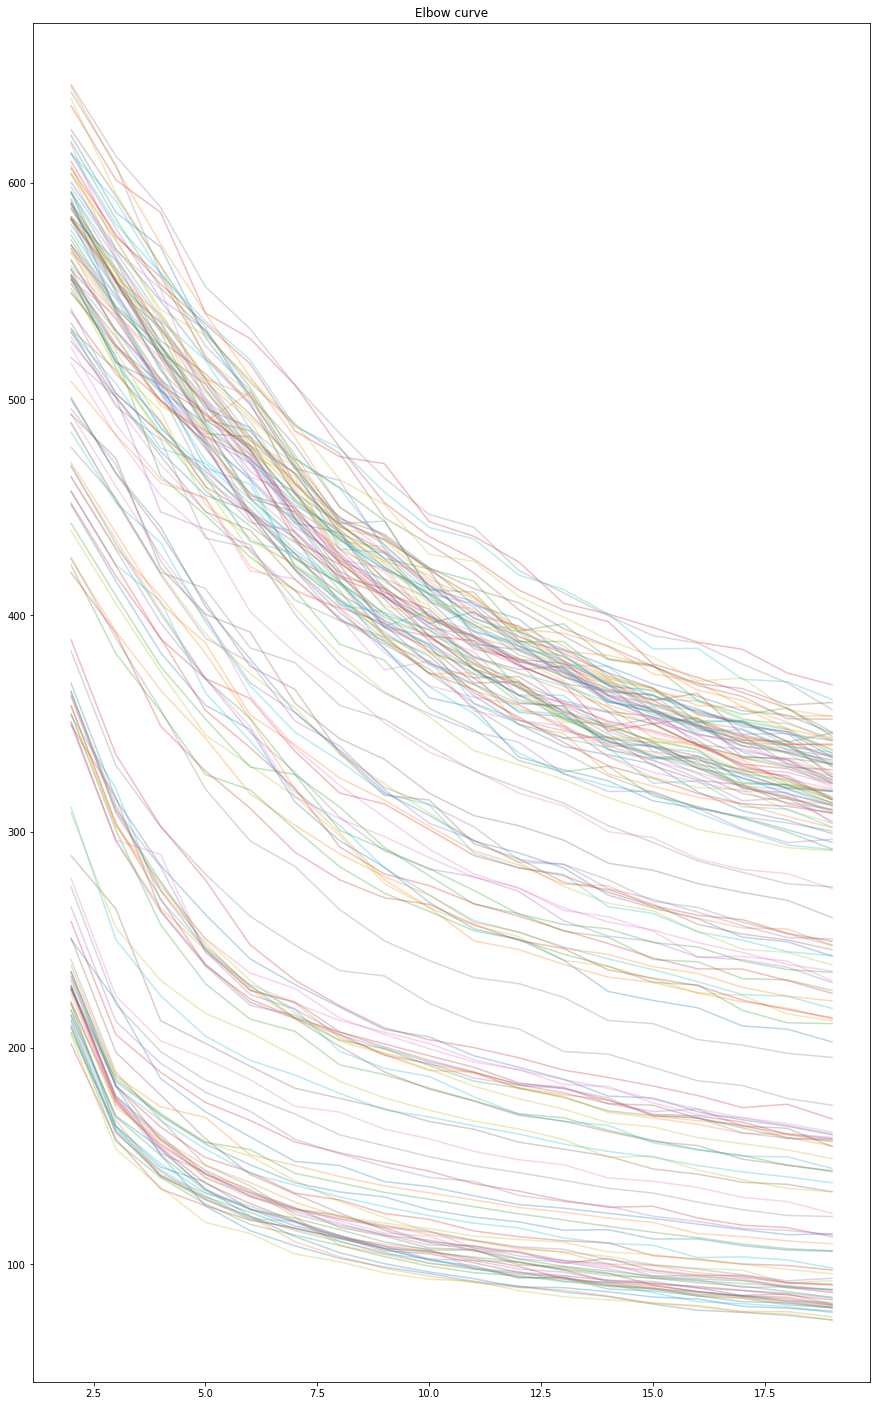

In [520]:
fig = plt.figure(figsize=(15, 25))

for i in range(z.shape[0]):
    plt.plot(range(2, kmax), z[i, :], alpha = 0.3)

plt.title('Elbow curve')
plt.show()

### Orthogonal features

In [488]:
def pcaAnalysis(dfX, threshold):
    
    # Standardization
    dfZ = dfX.sub(dfX.mean(), axis = 1).div(dfX.std(), axis = 1)
    
    # Singular value decomposition
    u, singVal, v = np.linalg.svd(dfZ, full_matrices = False)
        
    # Eigenvalues
    sigMatrix = np.diag(singVal)
    eVal = np.diag(sigMatrix ** 2)
    eValProp = eVal / eVal.sum()
    eValPropCum = eVal.cumsum() / eVal.sum()
    
    # Scores has the data projected to the PC space
    colNames = ['PC_' + str(i+1) for i in range(singVal.shape[0])]
    scores = pd.DataFrame(np.dot(u, sigMatrix), index = dfX.index, columns = colNames)
    scoresThresh = scores[scores.columns[range(len(eValPropCum[eValPropCum <= threshold]))]]
     
    # Loadings (eigenvectors)
    loadings = pd.DataFrame(v.transpose(), index = dfX.columns, columns = colNames)
    
    # Correlations
    correlations = pd.DataFrame(index = dfX.columns, columns = colNames[:len(eValPropCum[eValPropCum <= threshold])])
    corrPval = pd.DataFrame(index = dfX.columns, columns = colNames[:len(eValPropCum[eValPropCum <= threshold])])
    
    for feat in correlations.index:
        for pc in correlations.columns:
            coorFeatPc = stats.pearsonr(dfZ[feat], scoresThresh[pc])
            correlations.loc[feat, pc] = round(coorFeatPc[0], 2)
            corrPval.loc[feat, pc] = round(coorFeatPc[1], 4)
    
    return(eValPropCum, scoresThresh, loadings, correlations, corrPval)

In [ ]:
# Preparing X data to function 'pcaAnalysis'
# xBar = pd.read_pickle(homePath + 'Data/xBar.pkl')
delCols = ['dtObs', 'dtStr', 'dtEnd']
dfX = xBar.loc[:, list(set(xBar.columns) - set(delCols))]

In [500]:
from scipy import stats

threshold = 0.95
eValPropCum, scoresThresh, loadings, \
    correlations, corrPval = pcaAnalysis(stk_by_fund_dt_perc, threshold)

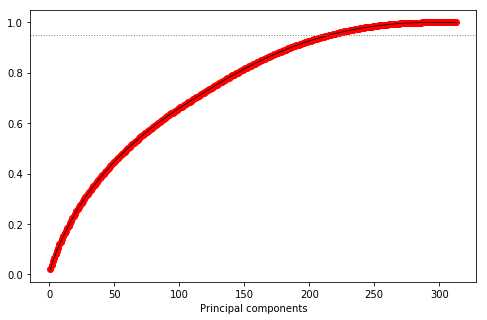

In [501]:
# Eigenvalues cum. importance
fig = plt.figure(figsize = (8, 5))
xAxis = list(range(1, len(eValPropCum)+1))
plt.plot(xAxis, eValPropCum, 'ro', xAxis, eValPropCum, 'k-', linewidth = 0.75)
plt.axhline(threshold, linewidth = 1, color = 'gray', linestyle = 'dotted')
plt.xlabel('Principal components')
plt.show()

In [ ]:
# Preparing Y data to plot classes in PC space
# yBar = pd.read_pickle(homePath + 'Data/yBar.pkl')
delCols = ['dtObs', 'dtStr', 'dtEnd']
dfY = yBar.loc[:, list(set(yBar.columns) - set(delCols))]

In [ ]:
# Plot first two PCs with class (Y) color
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
dfTemp = scoresThresh.loc[:, ['PC_1', 'PC_2']]
dfTemp['Y'] = dfY
ax.scatter(dfTemp['PC_1'], dfTemp['PC_2'], alpha = 0.2, s = 15, c = dfTemp['Y'])
plt.show()

In [ ]:
# Gov. Bonds and Money Mrkt position by funds, ISIN and date (data frame)
dfPosition = pd.concat([titpub_by_fund, opcompr_by_fund], axis = 1)

In [ ]:
# Save data frame
dfPosition.to_pickle(strucPath + 'positions_dfs/govBonds_mmrkt.pkl')